In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
from mpl_toolkits.axes_grid1 import make_axes_locatable
sz_ft = 18
sz_lb = 18
from tqdm import tqdm
import cosmo
import lensing_estimator
from cosmo import CosmoCalc
import lensing
import foregrounds as fg
import experiments as exp
import sims
import stats
import tools

In [2]:
nber_clus = 3000
nber_rand = 50000
nber_cov = 1000
map_params = [180, 0.5, 180, 0.5]
noiseval = 2 # uK-arcmin
beamval = 1 # arcmin
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = beamval)
l, nl = exp.white_noise_power_spectrum(noiseval_white = noiseval)
l, cl_noise =exp.white_noise_power_spectrum(noiseval_white = noiseval, beam_fwhm = beamval)
z = 0.7
cluster_6e14 = [6e14, cosmo.concentration_parameter(6e14, z, 0.674), z]
mass_int = np.arange(0, 12, 0.1)

/Volumes/Extreme_SSD/codes/master_thesis/code/cosmo.py:98: RuntimeWarning: invalid value encountered in true_divide
  cl = dl * 2 * np.pi / (l*(l+1))


In [3]:
%%script false --no-raise-error

maps_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl, nber_obs = nber_rand)
stack_bg = lensing_estimator.stack(map_params, maps_rand, l = l, cl = cl, cl_noise = cl_noise)
del maps_rand
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy', stack_bg) 

In [4]:
%%script false --no-raise-error

covariance_matrix, correlation_matrix = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl, cl_noise = cl_noise)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy', covariance_matrix) 
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/correlation_matrix_3000clus_2uK-arcmin.npy', correlation_matrix) 

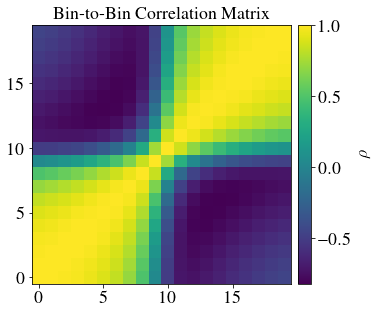

In [5]:
correlation_matrix = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/correlation_matrix_3000clus_2uK-arcmin.npy')   

fig, ax = plt.subplots(figsize=(5,5))
_, extent = tools.make_grid(map_params)

im = ax.imshow(correlation_matrix, origin = 'lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = fig.colorbar(im, cax = cax)
cb.set_label(label=r'$\rho$', size=sz_ft)
cb.ax.tick_params(labelsize=sz_lb)
ax.tick_params(labelsize = sz_lb)
ax.set_title('Bin-to-Bin Correlation Matrix', fontsize = sz_ft)

plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/correlation_matrix_example.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

In [6]:
%%script false --no-raise-error

model_profiles = lensing_estimator.model_profiles(nber_clus, map_params, l, cl, mass_int, z, bl = bl, cl_noise = cl_noise)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_0e14_12e14_0.1e14.npy', model_profiles) 

In [7]:
%%script false --no-raise-error

stack_bg = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy')   
covariance_matrix = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy')  
model_profiles = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_0e14_12e14_0.1e14.npy')    


maps_clus_6e14 = sims.cmb_mock_data(map_params, l, cl, cluster = cluster_6e14, bl = bl, nl = nl, nber_obs = nber_rand)
stack_clus_6e14 = lensing_estimator.stack(map_params, maps_clus_6e14, l = l, cl = cl, cl_noise = cl_noise)
bins_6e14, lensing_dipole_profile_6e14, stack_dipole_6e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_6e14, stack_bg)
data_6e14 = bins_6e14, lensing_dipole_profile_6e14, covariance_matrix
likelihood_6e14, mass_6e14, error_6e14 = stats.run_ml(data_6e14, model_profiles, mass_int)
mass_int_lk_6e14, lk_6e14 = likelihood_6e14

del maps_clus_6e14

  
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_6e14.npy', lk_6e14)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_6e14.npy', mass_6e14)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_6e14.npy', error_6e14) 

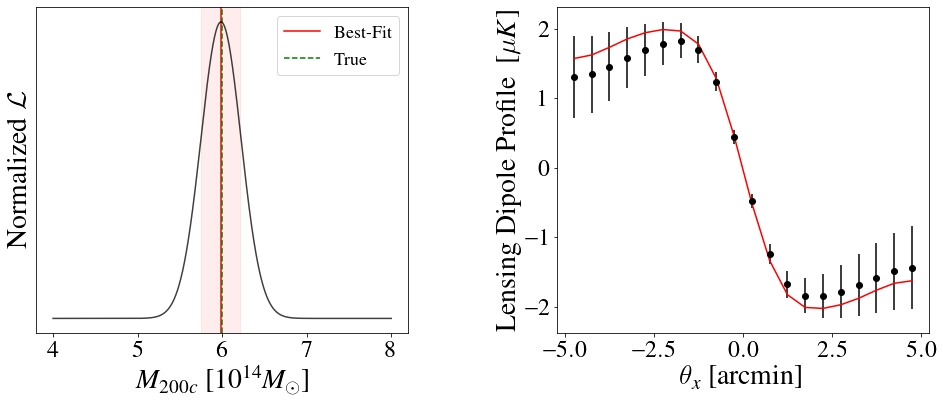

In [8]:
covariance_matrix = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy')  
model_profiles = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_0e14_12e14_0.1e14.npy')    
lk_6e14 = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_6e14.npy')
mass_6e14 = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_6e14.npy')
error_6e14 = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_6e14.npy') 
lensing_dipole_profile_6e14 = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lensing_dipole_profile_6e14.npy') 


nx, dx = map_params[0], map_params[1]
mass_int_finer = np.arange(min(mass_int), max(mass_int), 0.001) 
bins = np.arange((-20*dx)/2., (20*dx)/2., dx)+dx/2.

fig, axs = plt.subplots(1, 2, gridspec_kw={'wspace': 0.4}, figsize=(16,6))
(ax1, ax2) = axs

ax1.errorbar(mass_int_finer[4000:8000], lk_6e14[4000:8000], color = 'black', alpha = 0.75)
ax1.axvspan(mass_6e14-error_6e14, mass_6e14+error_6e14, alpha = 0.07, color = 'red')
ax1.axvline(mass_6e14, color = 'red', ls = '-', label = 'Best-Fit')
ax1.axvline(6, color = 'green', ls = '--', label = 'True')
ax1.set_xlabel(r'$M_{200c} \ [10^{14}M_\odot]$', fontsize = sz_ft+10)   
ax1.set_ylabel('Normalized '+r'$\mathcal{L}$', fontsize = sz_ft+10)
ax1.tick_params(labelsize = sz_lb+6)
ax1.axes.yaxis.set_ticks([])
ax1.legend(prop={'size': sz_lb})
ax2.errorbar(bins, lensing_dipole_profile_6e14, yerr = np.sqrt(np.diagonal(covariance_matrix)), marker = 'o', ecolor = 'black', color = 'black', ls = '')
ax2.plot(bins, model_profiles[60], color = 'red')
ax2.set_xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = sz_ft+10)
ax2.set_ylabel(r'Lensing Dipole Profile $\ [\mu K]$', fontsize = sz_ft+10)
ax2.tick_params(labelsize = sz_lb+6)
plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/lensing_estimator_output_example.pdf', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)